In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

sns.set(style="ticks")

# Credit Card Fraud
https://www.kaggle.com/mlg-ulb/creditcardfraud

## Features
---------------
- __Time:__ seconds elapsed fromfirst transaction in dataset
- __V1-V28:__ PCA components
- __Class:__ 1 fraud / 0 otherwise
- __Amount:__ transaction amount

In [2]:
data_dir = Path.cwd() / 'data'
pkl_dir = data_dir / 'pkl'

credit = pd.read_pickle(pkl_dir / 'credit_train.pkl')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
68806,53150.0,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,...,3.020385,-0.539618,0.033156,-0.774946,0.105868,-0.430853,0.229737,-0.070591,12.95,0
40018,40060.0,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,...,-0.172147,-0.574730,0.036834,-0.303782,0.073315,0.810356,-0.069178,0.001890,25.57,0
250360,154865.0,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,...,-0.528432,-1.251300,0.455607,-0.120530,-0.361515,-1.099295,0.052747,-0.032622,6.90,0
234820,148130.0,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,...,0.201104,0.757245,-0.013600,-0.079318,0.234805,-0.098151,0.000028,-0.031675,4.55,0
10001,15014.0,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,...,-0.363839,-0.458101,0.164097,0.234167,-0.418734,-0.074078,-0.355165,-0.169616,3.79,0


No need to clean the values of the data. There are no null values, and the data types are already numeric.

In [3]:
print(f"Data types: {np.unique(credit.dtypes)}")
print(f"Null values: {credit.isna().sum().sum()}")

Data types: [dtype('int64') dtype('float64')]
Null values: 0


In [4]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94832.242876,0.002930,-0.000877,-0.001470,0.001131,-0.001714,-0.001035,-0.000411,-0.001360,-0.000018,...,0.000266,0.000300,-0.000276,0.000687,0.000192,-0.000584,-0.000574,-0.000135,88.630203,0.001716
std,47500.701858,1.955265,1.649672,1.515055,1.416360,1.365962,1.326404,1.225317,1.205508,1.099972,...,0.737593,0.726705,0.623074,0.605268,0.520835,0.481943,0.401394,0.320750,248.037789,0.041390
min,0.000000,-46.855047,-63.344698,-33.680984,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54202.000000,-0.919898,-0.599013,-0.894424,-0.847412,-0.693585,-0.769201,-0.553573,-0.209145,-0.644499,...,-0.228658,-0.543193,-0.161766,-0.354153,-0.316644,-0.327647,-0.070776,-0.052865,5.690000,0.000000
50%,84737.000000,0.021886,0.063972,0.177138,-0.017538,-0.055515,-0.274916,0.039988,0.021545,-0.050353,...,-0.028974,0.006970,-0.010914,0.041164,0.017429,-0.052443,0.001091,0.011171,22.000000,0.000000
75%,139337.000000,1.316871,0.802516,1.026049,0.744471,0.610153,0.397215,0.569938,0.325849,0.597788,...,0.187107,0.529867,0.147642,0.439916,0.350742,0.240840,0.090529,0.078142,77.600000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000,1.000000


## Class Imbalance
------------------------

In [5]:
classes, counts = np.unique(credit['Class'], return_counts=True)

maj_cls_size = counts.max()
min_cls_size = counts.min()

maj_cls_label = classes[counts == maj_cls_size].item()
min_cls_label = classes[counts == min_cls_size].item()

cls_ratio = min_cls_size / maj_cls_size

print(f"{min_cls_size} minority class samples")
print(f"{maj_cls_size} majority class samples")
print(f"{cls_ratio:.5%} class imbalance")

391 minority class samples
227454 majority class samples
0.17190% class imbalance


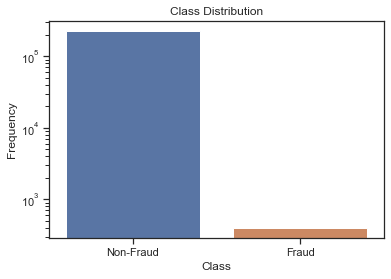

In [6]:
counts = credit['Class'].value_counts()
labels = ['Non-Fraud', 'Fraud']
ax = sns.barplot(x=labels, y=counts, log=True)
ax.set(xlabel='Class', ylabel='Frequency', title='Class Distribution');

## Time
----------

Observe that there are two days worth of data.

In [7]:
max_seconds = credit['Time'].max()
max_seconds

172792.0

In [8]:
day_seconds = 24 * 60 * 60

predicate = lambda x: x - day_seconds <= max_seconds
iterable = (day_seconds * i for i in itertools.count())
tuple(itertools.takewhile(predicate, iterable))

(0, 86400, 172800)

When graphed, we can clearly see a two day cycle of how many transactions are undergone during the day. I'll assume that the peaks are during daytime and the valleys are at night.

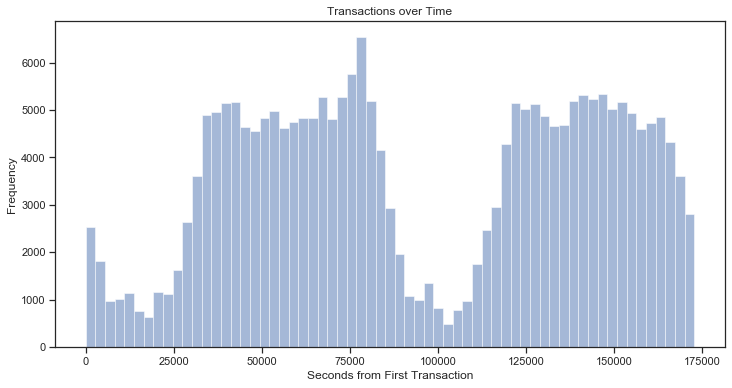

In [45]:
bins = len(np.histogram_bin_edges(credit['Time'], bins='auto'))

plt.figure(figsize=(12, 6))
plt.hist(credit['Time'], bins=bins, alpha=0.5)
plt.title('Transactions over Time')
plt.xlabel('Seconds from First Transaction')
plt.ylabel('Frequency');

Let's regularize this to have a column for the hour of the day rather than time from the first transaction. Assume midnight occurs at the minimums.

In [47]:
class TimeToHour(TransformerMixin):
    def fit(self, X, y=None):
        cuts = pd.cut(X['Time'], bins)
        counts = cuts.value_counts()
        midnight = int(counts.index[-1].mid)
        self.midnight = midnight
        return self

    def transform(self, X):
        hour_seconds = 60 * 60
        X['Hour'] = ((X['Time'] - self.midnight) % day_seconds) / hour_seconds
        return X
    
credit = TimeToHour().fit_transform(credit)

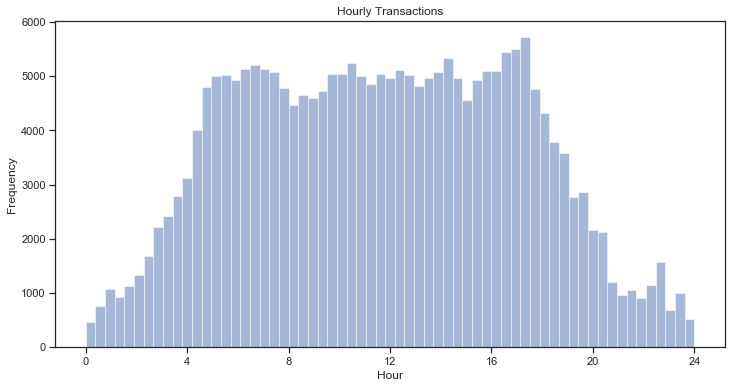

In [51]:
# plt.figure(figsize=(12, 6))
# ax = sns.distplot(credit['Hour'])
# ax.set(xticks=range(0, 25, 4), xlabel='Hour', ylabel='Density', title='Hourly Transactions');

plt.figure(figsize=(12, 6))
plt.hist(credit['Hour'], bins=bins, alpha=0.5)
plt.title('Hourly Transactions')
plt.xticks(range(0, 25, 4))
plt.xlabel('Hour')
plt.ylabel('Frequency');

## Non-Fraud vs Fraud
-----------------------------

In [13]:
is_fraud = credit['Class'] == min_cls_label

nonfraud = credit[~is_fraud]
fraud = credit[is_fraud]

nf_desc = nonfraud.describe()['Amount']
nf_desc.name = 'Not Fraud'

fr_desc = fraud.describe()['Amount']
fr_desc.name = 'Fraud'

pd.concat([nf_desc, fr_desc], axis=1)

,Not Fraud,Fraud
count,227454.000000,391.000000
mean,88.566586,125.638107
std,248.005952,263.658004
min,0.000000,0.000000
25%,5.740000,1.000000
50%,22.000000,14.460000
75%,77.500000,106.270000
max,19656.530000,2125.870000


In [108]:
# credit.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Log1pAmount', 'Hour'],
      dtype='object')

In [109]:
# sns.violinplot('Log1pAmount', data=credit, hue='Class', split=True)

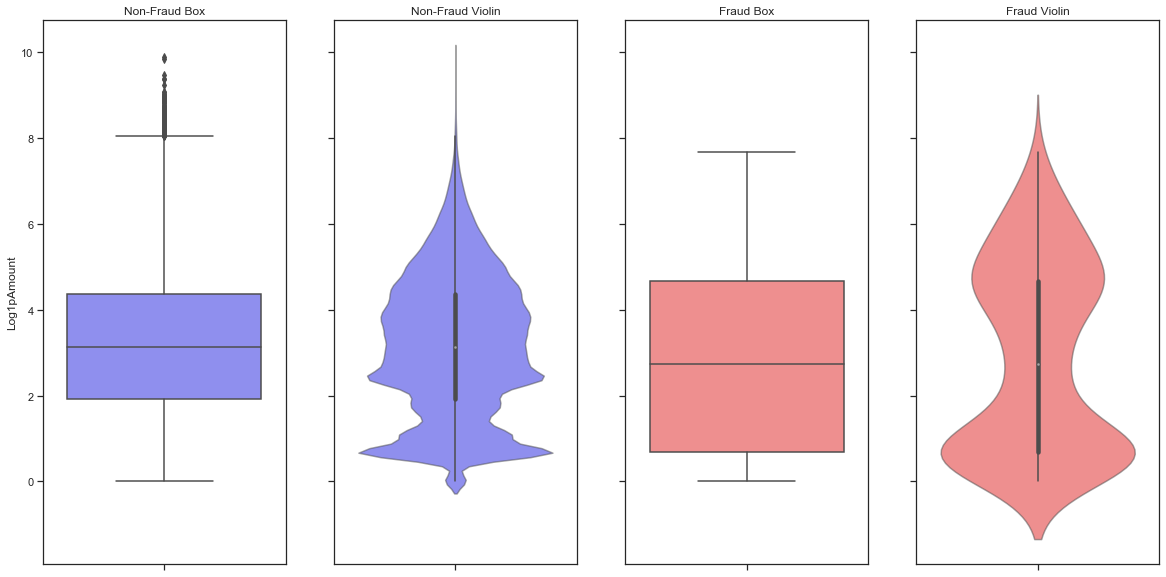

In [115]:
# sns.violinplot(fraud['Amount'])
# sns.violinplot(fraud['Log1pAmount'])
fig, axes = plt.subplots(1, 4, figsize=(20, 10), sharey=True)

sns.violinplot(nonfraud['Log1pAmount'], orient='v', color='blue', ax=axes[1])
sns.violinplot(fraud['Log1pAmount'], orient='v', color='red', ax=axes[3])

sns.boxplot(nonfraud['Log1pAmount'], orient='v', color='blue', ax=axes[0])
sns.boxplot(fraud['Log1pAmount'], orient='v', color='red', ax=axes[2])

alpha = 0.5
for ax in axes:
    plt.setp(ax.collections, alpha=alpha)  # voilin

    for patch in ax.artists:  # box
        r, g, b, _ = patch.get_facecolor()
        patch.set_facecolor((r, g, b, alpha))
        
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[3].set_ylabel(None)

axes[0].set_title('Non-Fraud Box')
axes[1].set_title('Non-Fraud Violin')
axes[2].set_title('Fraud Box')
axes[3].set_title('Fraud Violin');

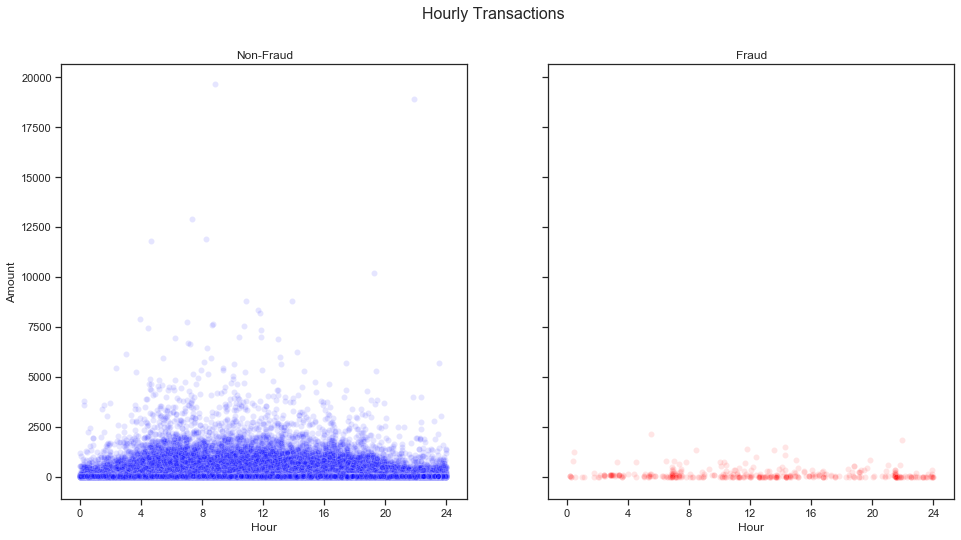

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)
fig.suptitle('Hourly Transactions', fontsize=16)

sns.scatterplot(nonfraud['Hour'], nonfraud['Amount'], alpha=0.1, color='blue', ax=axes[0])
axes[0].set_title('Non-Fraud')
axes[0].set_xticks(range(0, 25, 4))
axes[0].set_ylabel('Amount')
sns.scatterplot(fraud['Hour'], fraud['Amount'], alpha=0.1, color='red', ax=axes[1])
axes[1].set_title('Fraud');

It is difficult to see any patterns at this scale, so let's take the Log(Amount + 1) since we want the data to be more vertically spread and don't want undefined logrithm values when Amount = 0.

In [15]:
credit['Log1pAmount'] = np.log1p(credit['Amount'])
nonfraud = credit[~is_fraud]
fraud = credit[is_fraud]

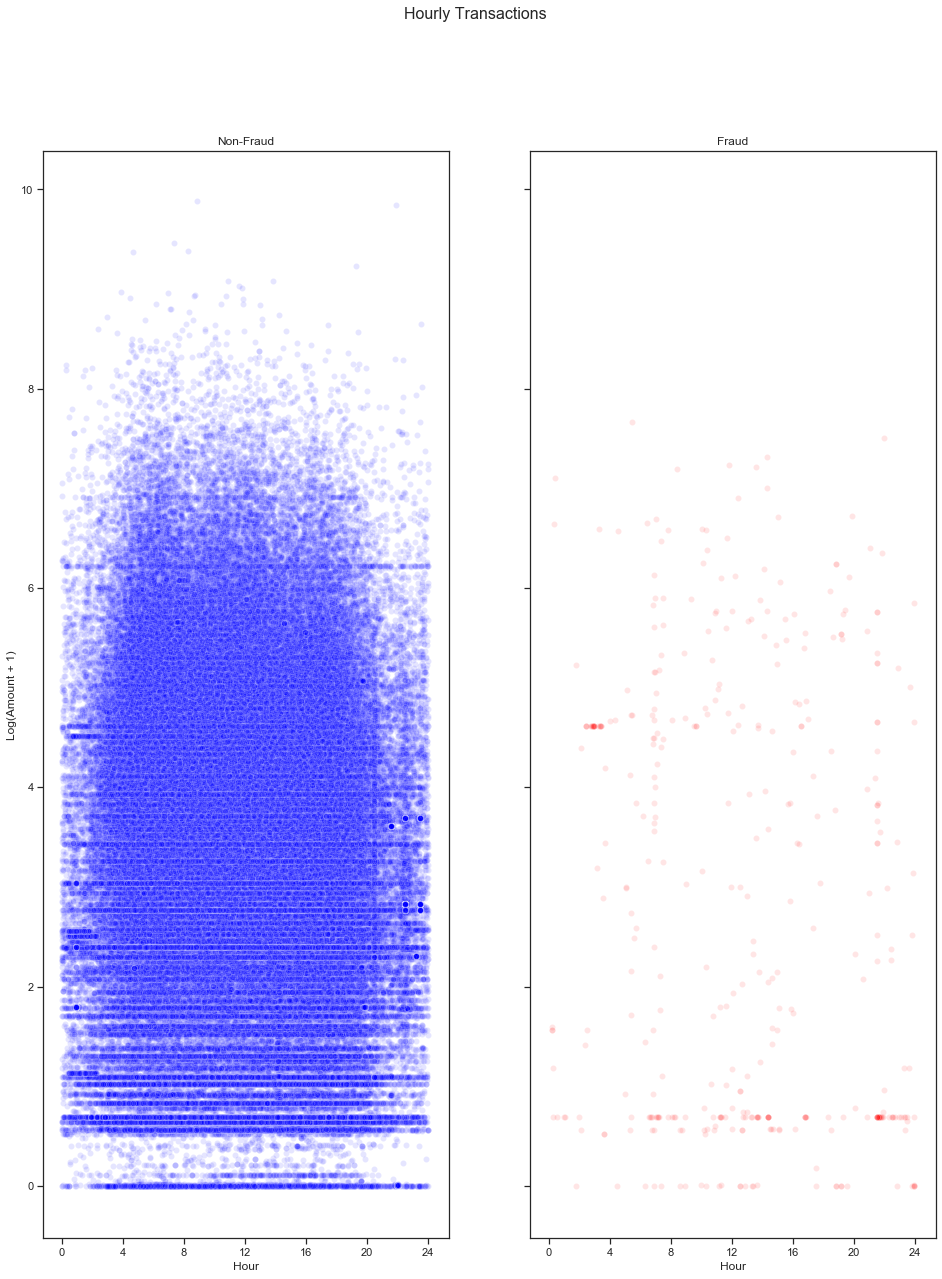

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 20), sharey=True, sharex=True)
fig.suptitle('Hourly Transactions', fontsize=16)

sns.scatterplot(nonfraud['Hour'], nonfraud['Log1pAmount'], alpha=0.1, color='blue', ax=axes[0])
axes[0].set_title('Non-Fraud')
axes[0].set_xticks(range(0, 25, 4))
axes[0].set_ylabel('Log(Amount + 1)')
sns.scatterplot(fraud['Hour'], fraud['Log1pAmount'], alpha=0.1, color='red', ax=axes[1])
axes[1].set_title('Fraud');

From this we can see horizontal bands which are indicative of people withdrawing "benchmark" amounts of money. For example, a transaction is more likely to be 100 dollars than 105.67 dollars.

In [17]:
def hex_plot(df1, df2, t1, t2, st='Hourly Transactions', x='Hour', y='Log1pAmount', c1='Blues', c2='Reds'):
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True, sharex=True)
    fig.suptitle('Hourly Transactions', fontsize=16)

    axes[0].hexbin(df1[x], df1[y], gridsize=10, cmap=c1)
    axes[0].set_title(t1)
    if x == 'Hour':
        axes[0].set_xticks(range(0, 25, 4))
    axes[0].set_xlabel(x)
    axes[0].set_ylabel(y)
    
    axes[1].hexbin(df2[x], df2[y], gridsize=10, cmap=c2)
    axes[1].set_title(t2)
    axes[1].set_xlabel(x)

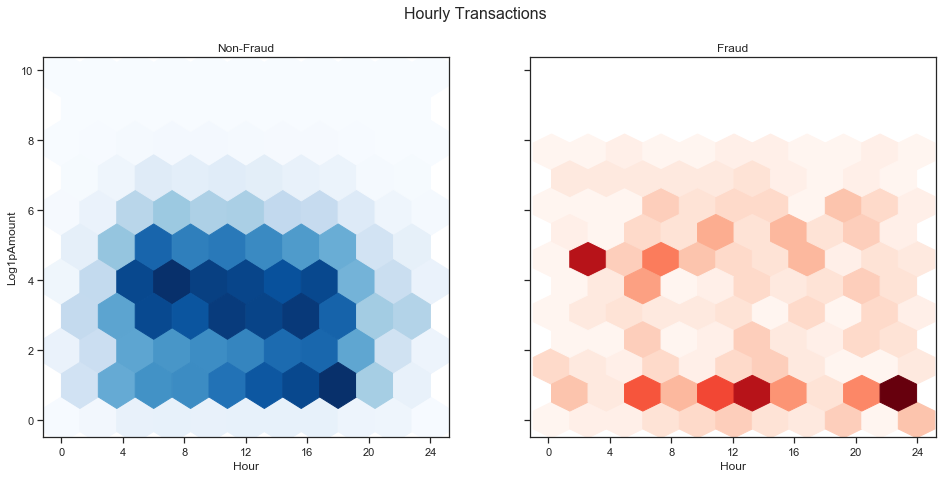

In [18]:
hex_plot(nonfraud, fraud, 'Non-Fraud', 'Fraud')

We can observe that non-fraudulent activity has a smaller density of transactions near 0 than fraudulent activity.

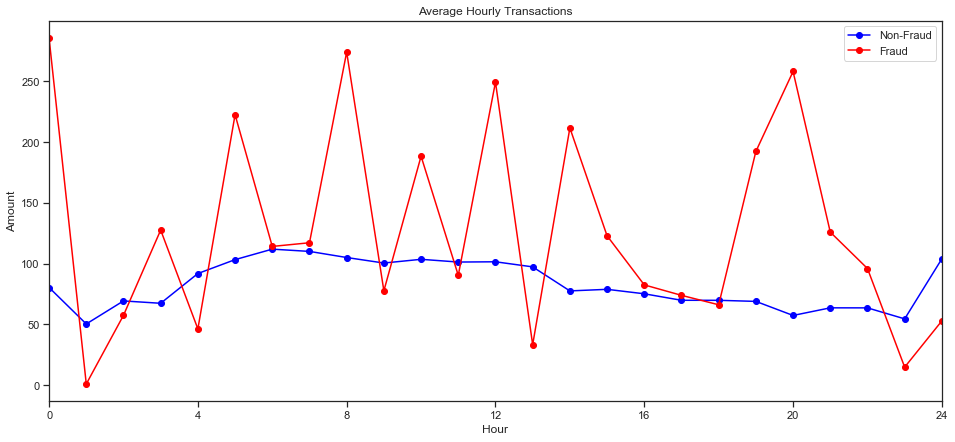

In [19]:
plt.figure(figsize=(16, 7))
nonfraud.groupby(nonfraud['Hour'].round())['Amount'].mean().plot(color='blue', marker='o', label='Non-Fraud')
fraud.groupby(fraud['Hour'].round())['Amount'].mean().plot(color='red', marker='o', label='Fraud')
plt.title('Average Hourly Transactions')
plt.legend(['Non-Fraud', 'Fraud'])
plt.xticks(range(0, 25, 4))
plt.ylabel('Amount');

On average, fraudsters make larger transactions.

## Outliers
--------------
Next, we will look for outliers in the data. I conjecture that non-fraud outliers would likely be confused with fraudulent data points.

In [20]:
lof = LocalOutlierFactor(contamination='auto')
lof_preds = lof.fit_predict(nonfraud)

nf_inliers = nonfraud[lof_preds == 1]
nf_in_desc = nf_inliers.describe()['Amount']
nf_in_desc.name = 'NF Inlier'

nf_outliers = nonfraud[lof_preds == -1]
nf_out_desc = nf_outliers.describe()['Amount']
nf_out_desc.name = 'NF Outlier'

pd.concat([nf_desc, nf_in_desc, nf_out_desc], axis=1)

,Not Fraud,NF Inlier,NF Outlier
count,227454.000000,223674.000000,3780.000000
mean,88.566586,81.228489,522.783931
std,248.005952,191.946814,1153.051281
min,0.000000,0.000000,0.000000
25%,5.740000,5.490000,46.140000
50%,22.000000,21.200000,147.545000
75%,77.500000,74.990000,396.825000
max,19656.530000,5114.100000,19656.530000


In [21]:
lof = LocalOutlierFactor(contamination='auto')
lof_preds = lof.fit_predict(fraud)

fr_inliers = fraud[lof_preds == 1]
fr_in_desc = fr_inliers.describe()['Amount']
fr_in_desc.name = 'Fr Inlier'

fr_outliers = fraud[lof_preds == -1]
fr_out_desc = fr_outliers.describe()['Amount']
fr_out_desc.name = 'Fr Outlier'

pd.concat([fr_desc, fr_in_desc, fr_out_desc], axis=1)

,Fraud,Fr Inlier,Fr Outlier
count,391.000000,337.000000,54.000000
mean,125.638107,129.722641,100.147593
std,263.658004,272.072534,203.667702
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,14.460000,17.390000,11.065000
75%,106.270000,108.510000,73.567500
max,2125.870000,2125.870000,802.520000


In [22]:
def display_outliers(df, title, column='Amount', ax=None):
    lof = LocalOutlierFactor(contamination='auto')
    pred = lof.fit_predict(df)
    
    is_outlier = (pred == -1)
    
    plt.figure(figsize=(20, 10))

    sns.kdeplot(df[~is_outlier][column], label='inliers', linewidth=3, shade=True, ax=ax)
    sns.kdeplot(df[is_outlier][column], label='outliers', linewidth=3, shade=True, ax=ax)

    plt.xlabel('Transaction Amount', fontdict=dict(fontsize=20))
    plt.ylabel('Density', fontdict=dict(fontsize=20))

    plt.legend(prop={'size': 20})
    plt.title(title, fontdict=dict(fontsize=40));

### Fraud Transactions

Fraud outlier and inlier KDE distributions overlap very closely.
- Both have peaks around 0.
- Outlier has slightly lower peak.
- Inlier has longer right tail.

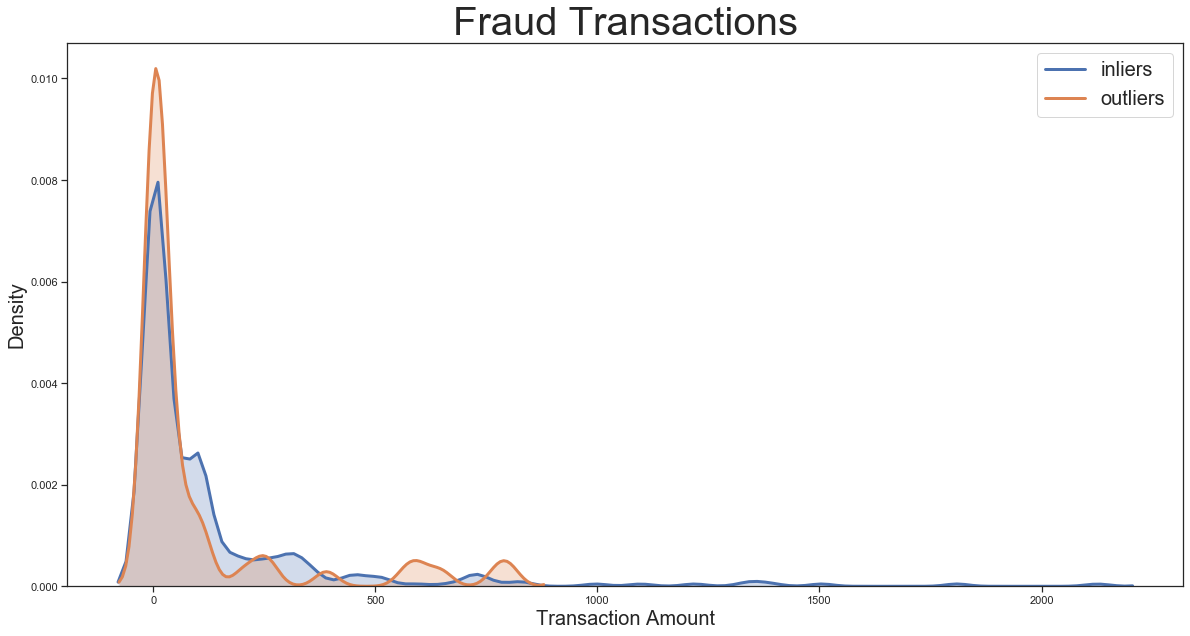

In [23]:
display_outliers(fraud, 'Fraud Transactions')

### Non-Fraud Transactions

Non-fraud outlier and inlier distributions are quite different than the fraud case.
- Outlier peak is not close to 0
- Inlier peak is half that of the outlier peak.
- Outlier has a huge right skew.

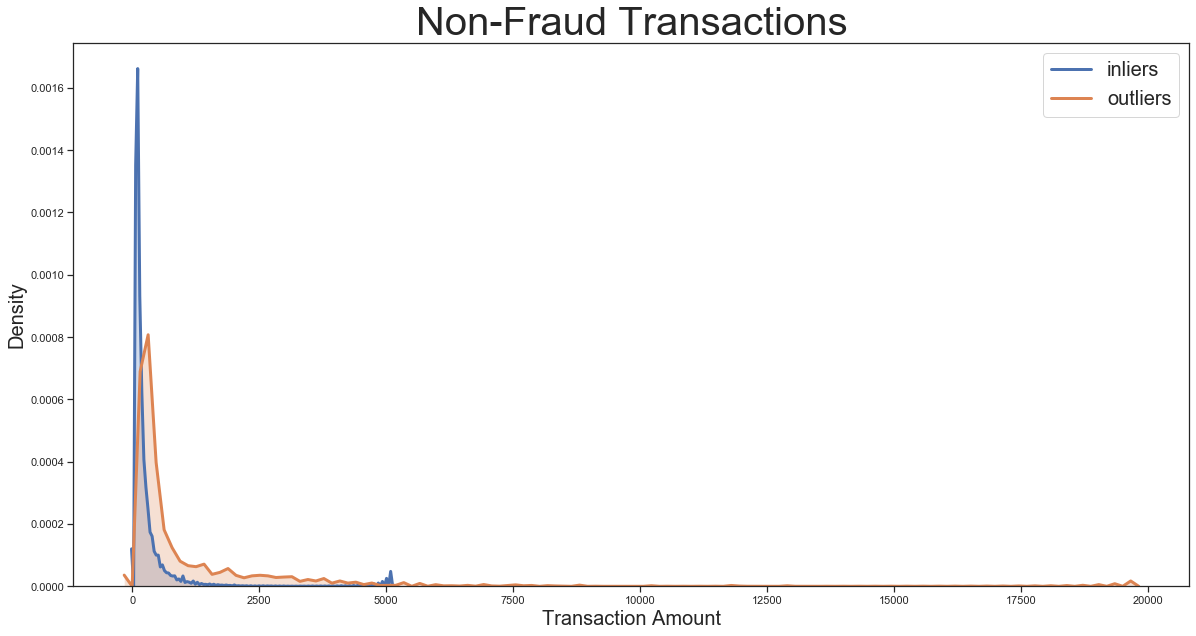

In [24]:
display_outliers(nonfraud, 'Non-Fraud Transactions')

We will remove these non-fraud outliers from the dataset to better detect fraudulent activity. This is acceptable since it only accounts for 1.6% of the dataset.

In [25]:
print(f"Outliers to non-fraud: {len(nf_outliers) / len(nonfraud)}")
print(f"Outliers to all data: {len(nf_outliers) / len(credit)}")

Outliers to non-fraud: 0.016618744889076473
Outliers to all data: 0.016590225811406876


### Inliers vs All

With both the non-fraud and fraud data, their inliers are in alignment with the dataset as a whole.

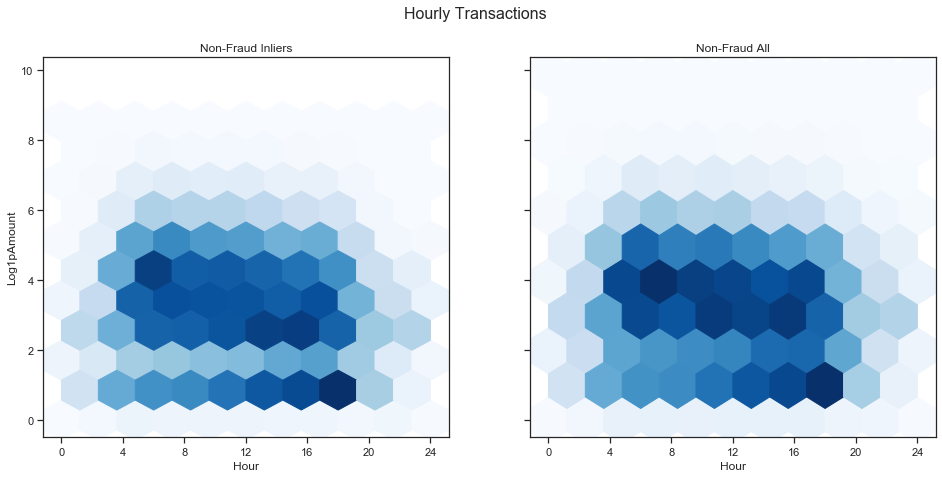

In [26]:
hex_plot(nf_inliers, nonfraud, 'Non-Fraud Inliers', 'Non-Fraud All', c2='Blues')

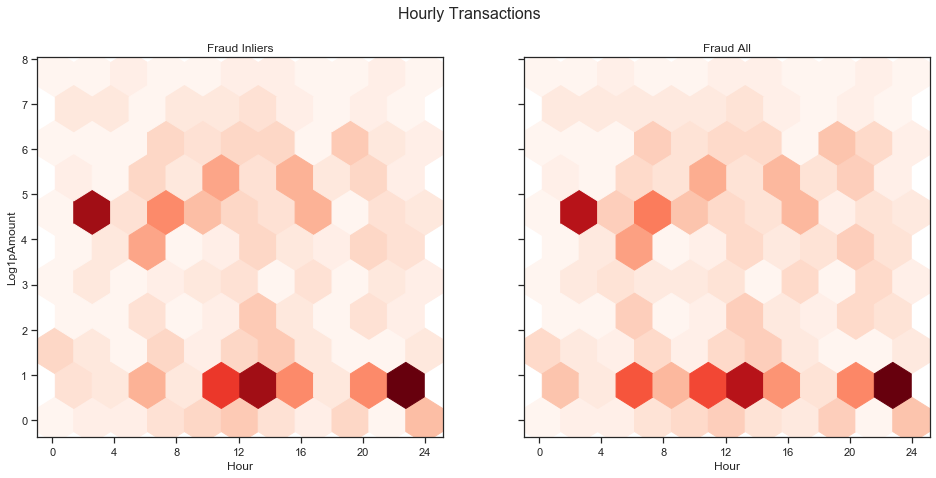

In [27]:
hex_plot(fr_inliers, fraud, 'Fraud Inliers', 'Fraud All', c1='Reds')

## Outliers vs All

Here we get interesting data as the density distributions of transaction amount vs time have drastically different graphs as would be expected.

### Non-Fraud
- Outliers tend to occur at nighttime
- The transaction amount is higher

### Fraud
- Avoiding middle of the day
- Avoiding midnight to early morning

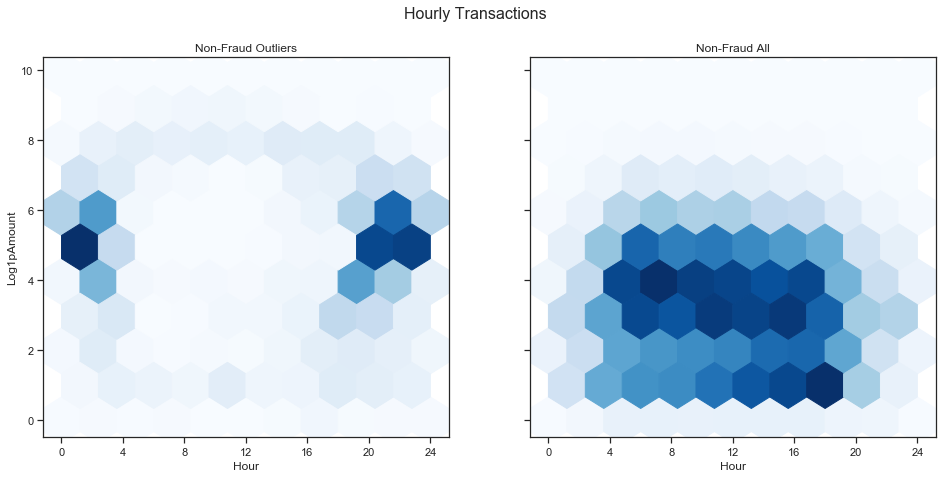

In [28]:
hex_plot(nf_outliers, nonfraud, 'Non-Fraud Outliers', 'Non-Fraud All', c2='Blues')

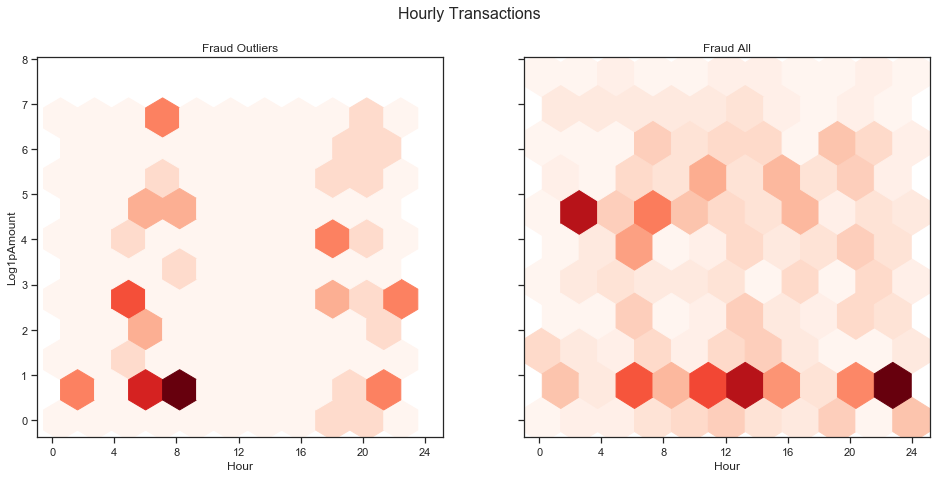

In [29]:
hex_plot(fr_outliers, fraud, 'Fraud Outliers', 'Fraud All', c1='Reds')